# Import library

In [481]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import datasketch   
from tqdm import tqdm

import nltk

In [482]:
fig_folder = "png"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# Import Dataset(The dataset after preprocessing)

In [483]:
print(os.getcwd())
path = os.path.abspath(os.path.join(os.getcwd(), "../data"))
print(path)
data = pd.read_csv(path + '/data_after_text_preprocessing.csv',index_col='id')

/Users/yusuke_sugihara/DA_Project1/DataAnalytics/Quora-question-pair-similarity
/Users/yusuke_sugihara/DA_Project1/DataAnalytics/data


In [484]:
data.shape

(404287, 8)

In [485]:
data.isnull().sum()

qid1             0
qid2             0
question1       14
question2        4
is_duplicate     0
word_common      0
word_total       0
word_share       0
dtype: int64

In [486]:
data[data.isnull().any(axis=1)]

,qid1,qid2,question1,question2,is_duplicate,word_common,word_total,word_share
id,,,,,,,,
3306,6553,6554,NaN,why is cornell own endowment the lowest in the...,0,0.0,10.0,0.0
13016,25026,25027,NaN,why should one not work at google,0,0.0,8.0,0.0
20072,37898,37899,how could i solve this,NaN,0,0.0,6.0,0.0
20794,39204,39205,NaN,what is the gmail tech support help phone number,0,0.0,10.0,0.0
47056,84067,84068,is there anywhere in the world offering pain m...,NaN,0,0.0,19.0,0.0
96725,161071,161072,NaN,who are moses noah and exodus,0,0.0,7.0,0.0
104101,171925,171926,NaN,problem of solving a problem is not a problem ...,0,0.0,18.0,0.0
134403,214814,214815,NaN,what is your take on the undercover report tha...,0,0.0,24.0,0.0
189659,161071,288480,NaN,who is noah,0,0.0,4.0,0.0


In [487]:
data = data.dropna(how="any").reset_index(drop=True)
data.shape

(404269, 8)

In [488]:
data['is_duplicate'].value_counts()

0    255006
1    149263
Name: is_duplicate, dtype: int64

In [489]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = data[['question1', 'question2']]
y = data['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train[:10000]
y_train = y_train[:10000]

print(X_train.head())
print(y_train.head())
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

                                                question1  \
360865  is it bad to sleep on your left side all the t...   
71770   why does not the quora app introduce an option...   
134765                          how do i clone a website    
302549        can people actively control their emotions    
100578  what were some of mother teresa own contributi...   

                                                question2  
360865          is it harmful to sleep on your left side   
71770   why does not the quora mobile app have an offl...  
134765                        how do you clone a website   
302549    how can i control my bad feelings and emotions   
100578  what is mother teresa own greatest accomplishm...  
360865    0
71770     1
134765    1
302549    1
100578    1
Name: is_duplicate, dtype: int64
(10000, 2)
(10000,)
(121281, 2)
(121281,)


In [490]:
com_data_train = X_train['question1'].append(X_train['question2']).reset_index()
print(com_data_train.head())


    index                                                  0
0  360865  is it bad to sleep on your left side all the t...
1   71770  why does not the quora app introduce an option...
2  134765                          how do i clone a website 
3  302549        can people actively control their emotions 
4  100578  what were some of mother teresa own contributi...


/var/folders/11/4w81_8697d9g_9c3944_ytwh0000gn/T/ipykernel_13355/3115984954.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com_data_train = X_train['question1'].append(X_train['question2']).reset_index()


In [491]:
# drop the index column because it is not needed for creating the dictionary
com_data_train.drop(['index'],axis=1,inplace=True) 
com_data_train.columns = ['question'] # rename the column
print(com_data_train.head())

                                            question
0  is it bad to sleep on your left side all the t...
1  why does not the quora app introduce an option...
2                          how do i clone a website 
3        can people actively control their emotions 
4  what were some of mother teresa own contributi...


In [492]:
print(com_data_train.shape)

(20000, 1)


## Making a dictionary mapping a question to its duplicate question

In [493]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

In [494]:
# Create a dictory of all dupllcated questions.
correct = X_train[y_train==1]
correct_dict = {}
for x,y in zip(correct['question1'],correct['question2']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]
for x,y in zip(correct['question2'],correct['question1']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]

## Set Representation

In [495]:
set_dict={} # maps question to set representation of question
norm_dict={} # maps question id (eg 'm1') to actual question. We may use this dictionary to evaluate results of LSH output.
count=1

for question in tqdm([x for x in com_data_train['question'] if type(x)==str]):
    temp_list = []
    for shingle in question.split(' '): # shingle is a word
        if shingle not in stop_words:
            temp_list.append(shingle.lower())
    set_dict["m{}".format(count)] = set(temp_list)
    norm_dict["m{}".format(count)] = question
    count +=1

100%|██████████| 20000/20000 [00:00<00:00, 284839.48it/s]


In [496]:
set_dict['m1']

{'', 'bad', 'left', 'side', 'sleep', 'time'}

In [497]:
norm_dict['m1']

'is it bad to sleep on your left side all the time '

In [498]:
num_perm = 256 # number of permutations for MinHash
min_dict = {} # maps question to "min hash signatures"
count2 = 1
for val in tqdm (set_dict.values()): 
    m = MinHash(num_perm=num_perm)
    for shingle in val:
        m.update(shingle.encode('utf8'))
    min_dict["m{}".format(count2)] = m
    count2+=1    
# print(min_dict['m1'].hashvalues)

100%|██████████| 20000/20000 [00:22<00:00, 879.82it/s]


In [499]:
def create_cand_pairs(lsh):
    big_list = []
    for query in min_dict.keys():
        bucket = lsh.query(min_dict[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

In [500]:
def evaluation(cand_pairs):
    tp = 0
    fp = 0
    fn = 0
    for pair in cand_pairs:
        if pair[1] == "None":
            if str(norm_dict[pair[0]]) in correct_dict.keys():
                    fn +=1
        else:
            if isinstance(correct_dict.get(norm_dict[pair[0]]), (list,)):
                if norm_dict[pair[1]] in correct_dict.get(norm_dict[pair[0]]):
                    tp +=1
                else:
                    fp +=1
                    
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    print ('precision is {:.2f}'.format(precision))
    print ('recall is {:.2f}'.format(recall))
    return precision, recall

In [503]:
lsh_list = []
precision_list = []
recall_list = []

for i in range(2,10):
    lsh = MinHashLSH(threshold=i/10, num_perm=num_perm)
    lsh_list.append(lsh)

for lsh in lsh_list:
    for key in tqdm(min_dict.keys()):
        lsh.insert(key,min_dict[key])
    precision, recall = evaluation(create_cand_pairs(lsh))
    
    precision_list.append(precision)
    recall_list.append(recall)

100%|██████████| 20000/20000 [00:06<00:00, 2898.29it/s]


precision is 0.00
recall is 1.00


100%|██████████| 20000/20000 [00:01<00:00, 11674.84it/s]


precision is 0.01
recall is 0.99


100%|██████████| 20000/20000 [00:02<00:00, 8510.86it/s] 


precision is 0.04
recall is 0.93


100%|██████████| 20000/20000 [00:02<00:00, 8757.81it/s] 


precision is 0.09
recall is 0.81


100%|██████████| 20000/20000 [00:02<00:00, 9242.38it/s] 


precision is 0.20
recall is 0.58


100%|██████████| 20000/20000 [00:00<00:00, 28359.02it/s]


precision is 0.28
recall is 0.43


100%|██████████| 20000/20000 [00:00<00:00, 39773.53it/s]


precision is 0.34
recall is 0.24


100%|██████████| 20000/20000 [00:00<00:00, 68065.15it/s]


precision is 0.35
recall is 0.14


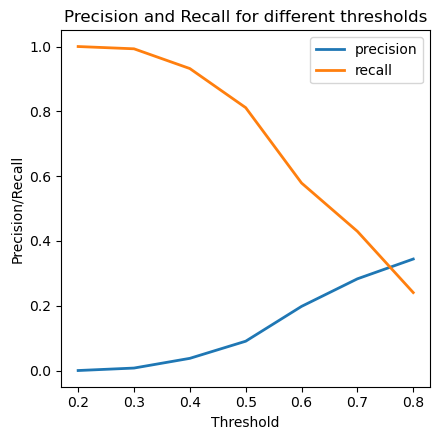

In [502]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
plt.plot([i/10 for i in range(2,9)],precision_list, label='precision', linewidth=2)
plt.plot([i/10 for i in range(2,9)],recall_list, label='recall',linewidth=2)
plt.title("Precision and Recall for different thresholds")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'precision_recall.png'), dpi=450)
plt.show()